In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping

In [188]:
# Cargar el dataset
df = pd.read_csv('combined_df.csv')

In [189]:
df.columns

Index(['Well', 'Depth', 'Clay', 'Quartz', 'Carbonates', 'TOC', 'Formation',
       'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
       'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens',
       'Jun_classif', 'Jun_unified', 'Jun_classif_classes',
       'Jun_unified_classes', 'TOC_class', 'well_number', 'Well Number'],
      dtype='object')

## Approach rápido

In [190]:
# Ejemplo: tus columnas de entrada
input_features = ['Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
                'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens']

target_mineral = 'Quartz'  # puedes cambiarlo luego por 'Carbonates' o 'Clays'

# Eliminar NaNs y escalar
df = df.dropna(subset=input_features + [target_mineral])
X = df[input_features].values
y = df[target_mineral].values.reshape(-1, 1)

In [191]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [192]:
# División
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Fancy PCA

In [171]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

def preprocess_and_augment(df, features, target, n_aug=5, noise_scale=0.08, test_size=0.2, random_state=42):
    # Limpieza básica
    df_clean = df.dropna(subset=features + [target]).copy()
    # Outliers (percentiles 1 y 99)
    q1, q99 = df_clean[target].quantile([0.01, 0.99])
    df_clean = df_clean[(df_clean[target] > q1) & (df_clean[target] < q99)]

    X = df_clean[features].values
    y = df_clean[[target]].values

    scaler_X = StandardScaler()
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=test_size, random_state=random_state
    )
    # Fancy PCA
    pca = PCA(n_components=min(X_train.shape[1], 8))
    X_pca = pca.fit_transform(X_train)
    X_augmented, y_augmented = [], []

    for _ in range(n_aug):
        noise = np.random.normal(0, noise_scale, X_pca.shape)
        X_pca_noisy = X_pca + noise
        X_noisy = pca.inverse_transform(X_pca_noisy)
        X_augmented.append(X_noisy)
        y_augmented.append(y_train)

    X_train_aug = np.vstack([X_train] + X_augmented)
    y_train_aug = np.vstack([y_train] + y_augmented)

    return X_train_aug, y_train_aug, X_test, y_test, scaler_X, scaler_y

In [172]:
features = ['Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
            'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens']
target = 'Quartz'   # Cambia por 'Carbonates' o 'Clay' según el mineral

X_train_aug, y_train_aug, X_test, y_test, scaler_X, scaler_y = preprocess_and_augment(
    df, features, target, n_aug=5, noise_scale=0.08
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_aug, y_train_aug, test_size=0.2, random_state=42
)

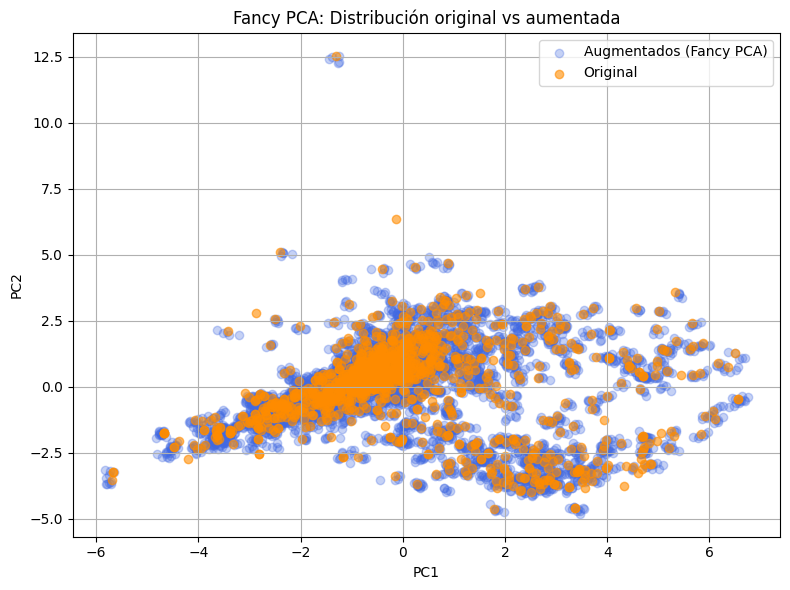

In [193]:
# Nota: X_train_aug incluye X_train original + augmentados (en orden)
# Así que los primeros N son los originales:
n_original = int(X_train_aug.shape[0] / (1 + 5))  # 5 = n_aug; ajusta según tu n_aug

# Mejor aún: como tu función apila así: [X_train] + X_augmented, puedes hacer:
n_original = X_train.shape[0]
X_augmented_only = X_train_aug[n_original:]  # solo los datos aumentados

# Ajusta el número de componentes si quieres ver solo 2D:
pca_vis = PCA(n_components=2)
pca_vis.fit(X_train_aug)  # Ajusta sobre todo el set aumentado

X_train_proj = pca_vis.transform(X_train)
X_aug_proj = pca_vis.transform(X_augmented_only)

plt.figure(figsize=(8, 6))
plt.scatter(X_aug_proj[:, 0], X_aug_proj[:, 1], label="Augmentados (Fancy PCA)", alpha=0.3, color='royalblue')
plt.scatter(X_train_proj[:, 0], X_train_proj[:, 1], label="Original", alpha=0.6, color='darkorange')
plt.title("Fancy PCA: Distribución original vs aumentada")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_fancy_pca_visual.png", dpi=300)
plt.show()

In [173]:
import keras_tuner as kt
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(X_train_aug.shape[1],)))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(layers.Dense(
            hp.Int(f'units_{i}', 32, 256, step=32),
            kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-4, 1e-2, sampling='log'))
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model

In [176]:
from tensorflow.keras.callbacks import EarlyStopping

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Puedes ajustar según tu tiempo/recursos
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='quartz_finetune'
)

early_stop = EarlyStopping(patience=20, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Trial 30 Complete [00h 01m 23s]
val_loss: 0.03364284709095955

Best val_loss So Far: 0.03080410696566105
Total elapsed time: 00h 36m 50s


In [177]:
best_model = tuner.get_best_models(1)[0]

c:\Users\juanc\anaconda3\envs\ICP_ML\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [178]:
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_real = scaler_y.inverse_transform(y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [179]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Mejores hiperparámetros encontrados:")
for param in best_hp.values.keys():
    print(f"{param}: {best_hp.values[param]}")

Mejores hiperparámetros encontrados:
n_layers: 2
units_0: 128
l2: 0.0013046810082496503
dropout: 0.0
lr: 0.00016468966822474475
units_1: 96
units_2: 192


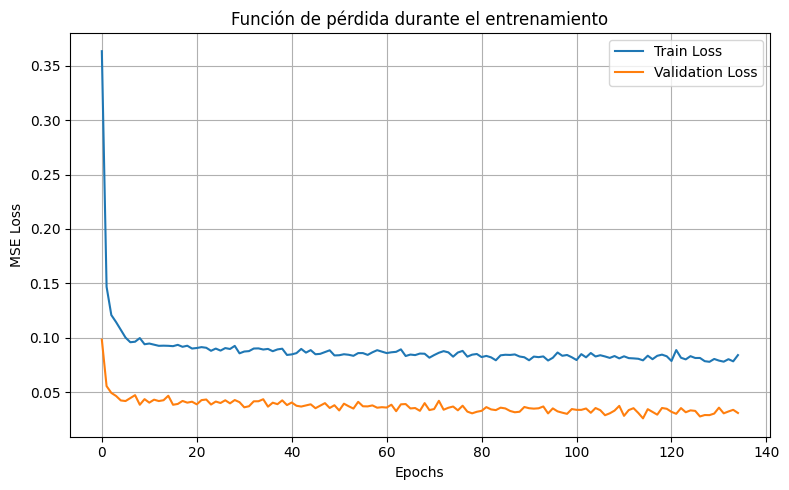

In [195]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Función de pérdida durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔹 MAE  = 15.550
🔹 RMSE = 18.838
🔹 R²   = 0.300


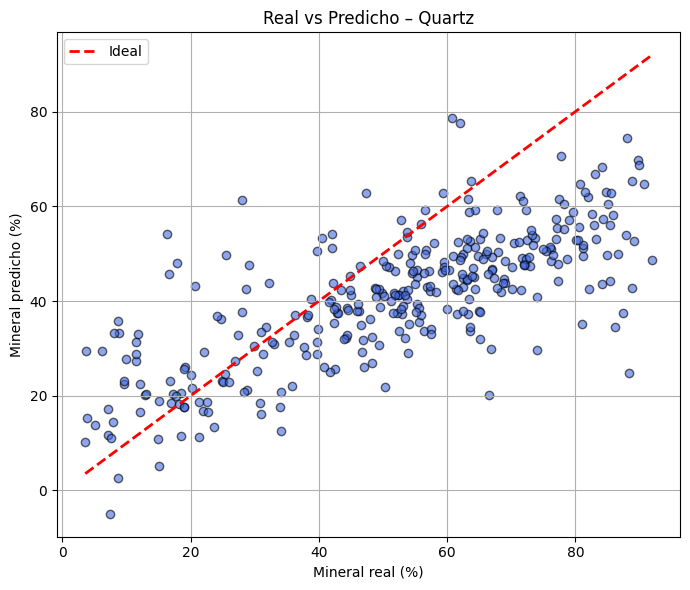

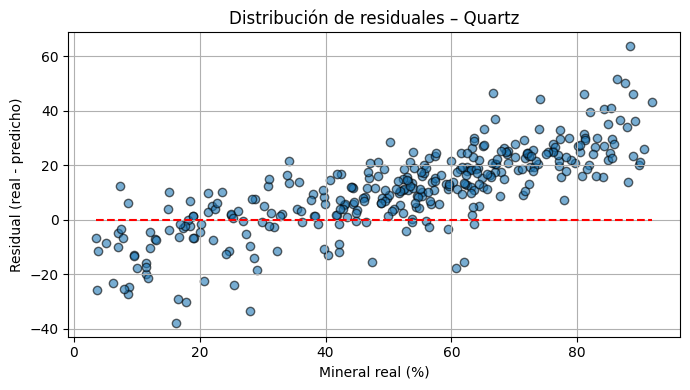

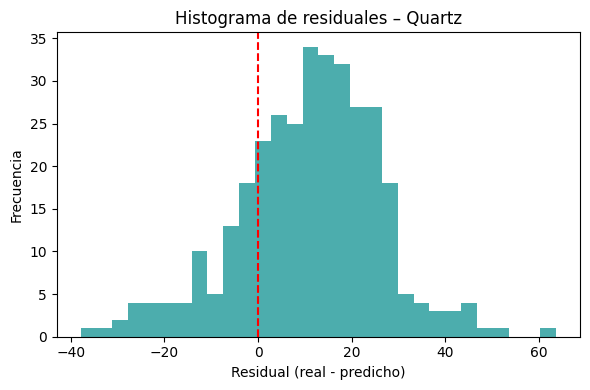

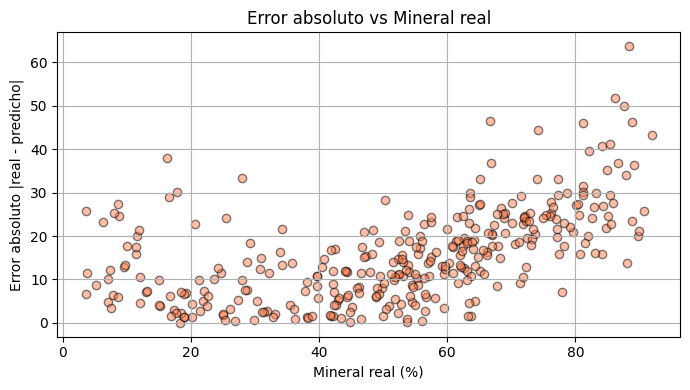

In [194]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print(f"🔹 MAE  = {mae:.3f}")
print(f"🔹 RMSE = {rmse:.3f}")
print(f"🔹 R²   = {r2:.3f}")

# Plot 1: Real vs Predicho
plt.figure(figsize=(7,6))
plt.scatter(y_real, y_pred, alpha=0.6, edgecolor='k', c='royalblue')
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Mineral real (%)')
plt.ylabel('Mineral predicho (%)')
plt.title('Real vs Predicho – Quartz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Residuales (real - predicho)
residuals = y_real - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_real, residuals, alpha=0.6, edgecolor='k')
plt.hlines(0, y_real.min(), y_real.max(), colors='r', linestyles='--')
plt.xlabel('Mineral real (%)')
plt.ylabel('Residual (real - predicho)')
plt.title('Distribución de residuales – Quartz')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Histograma de residuales
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='darkcyan', alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.title('Histograma de residuales – Quartz')
plt.xlabel('Residual (real - predicho)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Plot 4: Error absoluto vs valor real
plt.figure(figsize=(7,4))
plt.scatter(y_real, np.abs(residuals), alpha=0.5, c='coral', edgecolor='k')
plt.xlabel('Mineral real (%)')
plt.ylabel('Error absoluto |real - predicho|')
plt.title('Error absoluto vs Mineral real')
plt.grid(True)
plt.tight_layout()
plt.show()